# Micro Mobility Prediction

This is the start for the project in course NGEN27.

#### load modules

In [25]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score,recall_score, ConfusionMatrixDisplay
import shapely
import folium 
import mapclassify
import osmnx as ox

#### load, select and split data

In [2]:
data = pd.read_csv('micromobility_choice.csv')
data.head()

,ID,slng,slat,elng,elat,duration,distance,elevation_difference,temperature,windSpeed,day_week,hour_day,restaurant,public facility,medical,accommodation,tourist attraction,transportation,education,TripType
0,0,8.496727,47.378521,8.490380,47.381591,194,587,0,10,7,0,22,0,1,0,0,0,0,0,1
1,1,8.537729,47.379719,8.523722,47.389900,5754,1547,3,0,4,1,6,0,1,0,0,0,1,0,1
2,2,8.510418,47.381356,8.523818,47.377148,442,1112,-4,6,4,1,17,2,2,0,0,0,0,0,1
3,3,8.535119,47.355189,8.536068,47.377502,1901,2482,-3,7,9,1,13,1,8,0,0,0,0,0,1
4,4,8.518982,47.386741,8.516692,47.389777,193,379,3,5,24,0,11,0,1,0,2,0,1,0,1


In [3]:
#data = data.drop('ID', axis = 'columns') # drop ID
X = data.drop(['TripType', 'ID'], axis = 'columns') # drop target and ID
y = data.iloc[:,-1:] # select target by dropping all features

In [4]:
# check for NA values
nan_check = data.isna().any().any()

if nan_check:
    print("There are NaN values in the DataFrame.")
else:
    print("There are no NaN values in the DataFrame.")

There are no NaN values in the DataFrame.


In [5]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, train_size = 0.70, random_state = 42)

#### Task 1:
Develop random forest classification model using scikit-learn python library to predict the choice
based on the features. In this task, you can keep the hyperparameters on default settings.

In [6]:
# set up RF classifier with default (hyper)parameter values 
RF_model = RandomForestClassifier(n_estimators=100, 
                       criterion='gini', 
                       max_depth=None, 
                       min_samples_split=2, 
                       min_samples_leaf=1, 
                       min_weight_fraction_leaf=0.0, 
                       max_features='sqrt', 
                       max_leaf_nodes=None, 
                       min_impurity_decrease=0.0, 
                       bootstrap=True, 
                       oob_score=False, 
                       n_jobs=None, 
                       random_state=None, 
                       verbose=0, 
                       warm_start=False, 
                       class_weight=None, 
                       ccp_alpha=0.0, 
                       max_samples=None, 
                       monotonic_cst=None)

# train random forest 
RF_model.fit(X_train, y_train)

C:\Users\Lenovo\anaconda3\envs\geoAI\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
# evaluation metric

y_pred = RF_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

In [8]:
### attention: this is now weighted averaging!
confusion = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(f"F1: {f1_score(y_test, y_pred, average = 'weighted')}")
print(f"Recall: {recall_score(y_test, y_pred, average = 'weighted')}")
print(f"Precision: {precision_score(y_test, y_pred, average = 'weighted')}")


F1: 0.7266890639748347
Recall: 0.7264444444444444
Precision: 0.7276530760873355


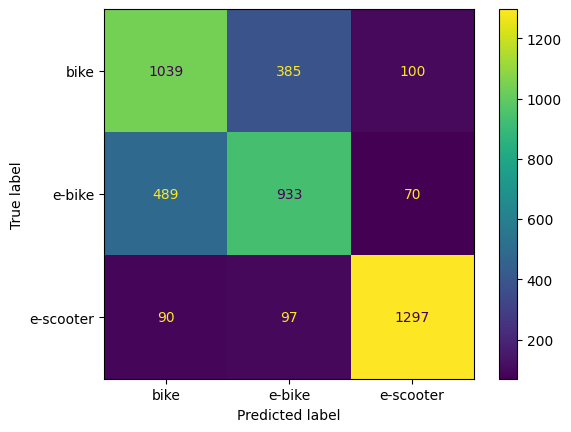

In [9]:
ConfusionMatrixDisplay(confusion, 
                      display_labels = ['bike', 'e-bike', 'e-scooter']).plot()

#### Task 2 

Implement hyperparameter tuning and develop the optimal random forest classification model.
Compare the prediction performance with that of the two models in Task 1.

#### feature selection

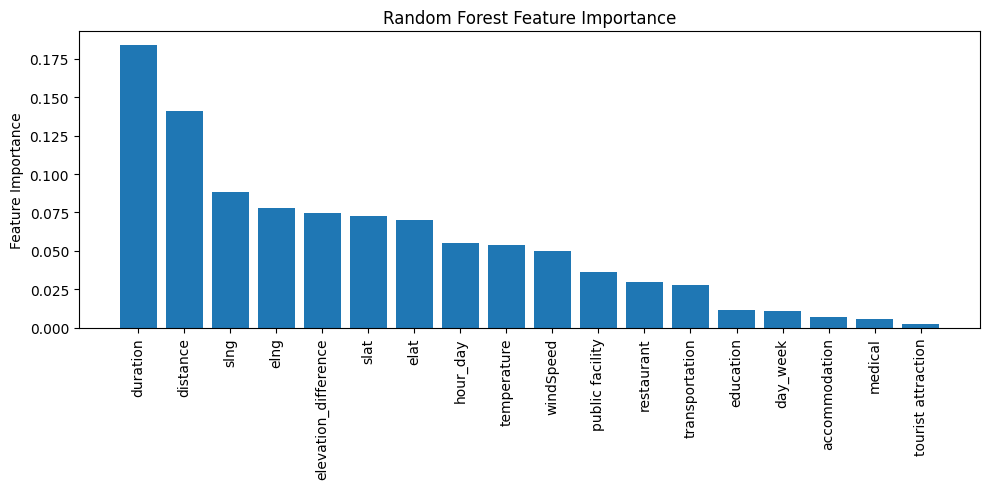

In [10]:
### explore for feature importance first

feature_importances = RF_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
indices = np.argsort(feature_importances)[::-1]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_importances)), feature_importances[indices], align='center')
plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90, fontsize=10)
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


#### hyperparameter tuning using random search


In [66]:
from sklearn.model_selection import RandomizedSearchCV

#### hyperparameter tuning using random search

In [74]:
param_distributions = {
    'n_estimators': [20, 50, 100, 200, 500, 750, 1000],
    'max_depth': [3, 5, 10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10]
}
random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions, n_iter=50, cv=5, n_jobs=-1, verbose = 3)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\Lenovo\anaconda3\envs\geoAI\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,estimator,RandomForestClassifier()
,param_distributions,"{'max_depth': [3, 5, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [20, 50, ...]}"
,n_iter,50
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


0.7368888888888889
F1: 0.7368953382259265
Recall: 0.7368888888888889
Precision: 0.7380817234337723


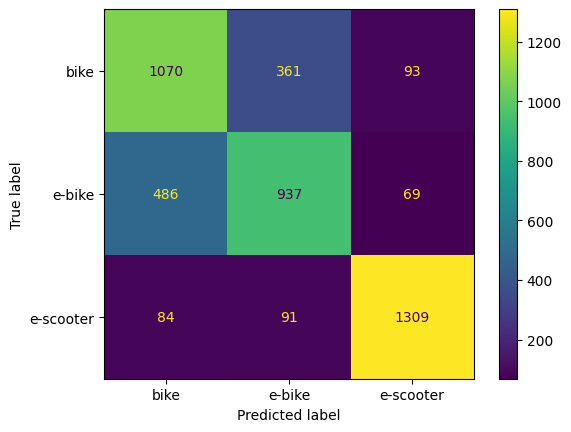

In [76]:
# predict test features
y_pred = random_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

### attention: this is now weighted averaging!
confusion = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(f"F1: {f1_score(y_test, y_pred, average = 'weighted')}")
print(f"Recall: {recall_score(y_test, y_pred, average = 'weighted')}")
print(f"Precision: {precision_score(y_test, y_pred, average = 'weighted')}")

# plot confusion matrix
ConfusionMatrixDisplay(confusion, 
                      display_labels = ['bike', 'e-bike', 'e-scooter']).plot()

#### Task 3

Conduct k-fold cross validation and calculate the average evaluation metrics: accuracy, precision,
recall and f1-score.

I'm not quite sure if this task actually makes sense here. I already use cross validation (5 fold) during the hyperparameter tuning.  

#### Task 4

Based on the model in Task 2, visualize the start and end points for the misclassified trips in maps.
The visualization for the three types of shared micro-mobility services should be implemented separately.

In [11]:
# prediction on whole data set
#y_pred_full = random_search.predict(X)
y_pred_full = RF_model.predict(X)

In [12]:
# join back in original data frame for plotting
preds = pd.DataFrame({'y_pred_full': y_pred_full})
data = data.join(preds)

In [13]:
# missclassified 
misclassified = data['y_pred_full'].eq(data['TripType']) # if false: misclassification
misclassified = pd.DataFrame({"misclassified":misclassified}) # make df for merging 
data = data.join(misclassified) # join by index

In [14]:
#select only misclassified data
mis_data = data[data["misclassified"] == False] # select only misclassified rows

In [15]:
mis_bike = mis_data[mis_data["TripType"]== 1] # select only bike for now

In [16]:
mis_bike.head()

,ID,slng,slat,elng,elat,duration,distance,elevation_difference,temperature,windSpeed,...,restaurant,public facility,medical,accommodation,tourist attraction,transportation,education,TripType,y_pred_full,misclassified
0,0,8.496727,47.378521,8.490380,47.381591,194,587,0,10,7,...,0,1,0,0,0,0,0,1,4,False
8,8,8.493822,47.398555,8.486002,47.396401,3965,636,2,9,11,...,0,0,0,0,0,1,0,1,4,False
14,14,8.518170,47.391784,8.531935,47.384918,580,1287,-7,11,48,...,0,5,0,0,0,4,0,1,2,False
15,15,8.541541,47.413733,8.535802,47.409964,140,602,-14,5,22,...,0,1,0,0,0,0,0,1,2,False
19,19,8.546464,47.403822,8.528647,47.382083,825,2764,60,10,4,...,1,2,0,0,0,1,0,1,2,False


In [17]:
# create a geopandas dataframe with the start and end points
points_start = gpd.GeoDataFrame(mis_bike, geometry=gpd.points_from_xy(x=mis_bike.slng, y=mis_bike.slat), crs = 'EPSG:4326')
points_end = gpd.GeoDataFrame(mis_bike, geometry=gpd.points_from_xy(x=mis_bike.elng, y=mis_bike.elat), crs = 'EPSG:4326')
print(points_start.shape)
print(points_end.shape)

# put together (kind of pivot longer manually)
mis_bike_start_end = pd.concat(objs = [points_start, points_end])
print(mis_bike_start_end.shape)

# use LineString function from shapely to create line from all rows with equal ID (just two, resulting in lines)
mis_bike_lines = mis_bike_start_end.groupby(['ID'])['geometry'].apply(lambda x:  shapely.LineString(x.tolist()))
mis_bike_lines.shape

# merge back lines:


(488, 23)
(488, 23)
(976, 23)


(488,)

In [18]:
mis_bike

,ID,slng,slat,elng,elat,duration,distance,elevation_difference,temperature,windSpeed,...,restaurant,public facility,medical,accommodation,tourist attraction,transportation,education,TripType,y_pred_full,misclassified
0,0,8.496727,47.378521,8.490380,47.381591,194,587,0,10,7,...,0,1,0,0,0,0,0,1,4,False
8,8,8.493822,47.398555,8.486002,47.396401,3965,636,2,9,11,...,0,0,0,0,0,1,0,1,4,False
14,14,8.518170,47.391784,8.531935,47.384918,580,1287,-7,11,48,...,0,5,0,0,0,4,0,1,2,False
15,15,8.541541,47.413733,8.535802,47.409964,140,602,-14,5,22,...,0,1,0,0,0,0,0,1,2,False
19,19,8.546464,47.403822,8.528647,47.382083,825,2764,60,10,4,...,1,2,0,0,0,1,0,1,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4952,4952,8.523306,47.368939,8.534227,47.360004,414,1290,6,3,4,...,2,1,0,0,0,1,0,1,2,False
4954,4954,8.535718,47.359675,8.548562,47.366910,591,1258,-7,8,9,...,7,4,0,0,0,2,0,1,2,False
4974,4974,8.488108,47.391366,8.518143,47.363148,1421,3868,-25,6,35,...,1,5,0,0,0,3,0,1,2,False
4978,4978,8.533314,47.373110,8.528074,47.393309,1790,2280,-18,7,15,...,0,1,0,0,0,1,0,1,2,False


In [19]:
mis_bike = mis_bike.merge(mis_bike_lines, on = "ID", how = "left")


In [20]:
mis_bike = gpd.GeoDataFrame(mis_bike, geometry = "geometry", crs = "EPSG:4326")

In [23]:
mis_bike.explore()

In [54]:
place_name = "Zürich, Schweiz"
Zürich_boundary = ox.geocode_to_gdf(place_name)

Zürich_admin = ox.features_from_place(
    place_name,
    tags={"boundary": "administrative", "admin_level": "9"}
)

Zürich_admin_9 = Zürich_admin[Zürich_admin["admin_level"] == "9"]

In [55]:
Zürich_admin_9.explore()